In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

In [2]:
# update_progress() : Displays or updates a console progress bar
## Accepts a float between 0 and 1. Any int will be converted to a float.
## A value under 0 represents a 'halt'.
## A value at 1 or bigger represents 100%
last_time = time.time()
def update_progress(progress,dispValue):
    global last_time
    barLength = 50 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% |{3}| {2}".format( "#"*block + "-"*(barLength-block), progress*100, status, dispValue)
    new_time = time.time()
    if new_time - last_time > 1:
        last_time = new_time
        sys.stdout.write(text)
        sys.stdout.flush()

In [30]:
class DataFile:
    def __init__(self, filePath, timeStart, timeEnd):
        self._readData(filePath, timeStart, timeEnd)
        self._calculateInfoIDs()
        self._createFlagColumns()
        self.timeStart = timeStart
        self.timeEnd = timeEnd
        
    def _readData(self, filePath, timeStart, timeEnd):
        df = pd.read_csv(filePath, parse_dates=['time'])
        df = df[(timeStart <= df.time) & (df.time < timeEnd)]
        self.df = df

    # Find all information IDs, Create unique infoID set column 'sortedInfoIDs'
    def _calculateInfoIDs(self):
        allInformationIDs = set()
        sortedInfoIDs = []
        for i,iidListList in enumerate(self.df.informationIDs.values):
            iidList = eval(str(iidListList))
            iidList.sort()
            sortedInfoIDs.append(str(iidList))
            for iid in iidList:
                allInformationIDs.add(iid)

        self.df['sortedInfoIDs'] = sortedInfoIDs
        allInformationIDs = list(allInformationIDs)
        allInformationIDs.sort()
        del sortedInfoIDs
        print(allInformationIDs)
        self.allInformationIDs = allInformationIDs

    # Create flag columns with each InfoID and fill the correct values.
    def _createFlagColumns(self):
        infoid_flags = {k:[] for k in self.allInformationIDs}

        for i,idlist in enumerate(self.df.informationIDs.values):
            checklist = set(self.allInformationIDs)
            for iid in eval(str(idlist)):
                infoid_flags[iid].append(True)
                checklist.remove(iid)
            for iid in checklist:
                infoid_flags[iid].append(False)

        for k in infoid_flags:
            self.df[k] = infoid_flags[k]

        del infoid_flags
        self.df.columns
        
    def _analyzeCascade(self, dfSubset, cascadeName):
        this_event_time_user = dfSubset[['time','userID']].reset_index(drop=True)
        adopted_users = set()
        adoption_series = [0 for i in range(this_event_time_user.shape[0])]
        for i,v in this_event_time_user.iterrows():
            if v.userID in adopted_users:
                adoption_series[i] = adoption_series[i-1]
            else:
                adopted_users.add(v.userID)
                adoption_series[i] = adoption_series[i-1] + 1

        if (len(adoption_series) <= 0) or (adoption_series[-1] < 100):
            return False
        this_event_time_user['adoption'] = adoption_series
        this_event_time_user['cascadeSize'] = list(range(1,this_event_time_user.shape[0]+1))
        print("shape: {}\ncols: {}".format(this_event_time_user.shape, this_event_time_user.columns))
        #print(this_event_time_user.tail())
        this_event_time_user.to_csv("./outputs/" + cascadeName + ".csv",index=False)
        this_event_time_user.set_index('time')[['adoption','cascadeSize']].plot()
        plt.title(cascadeName)
        plt.xlabel('count')
        plt.savefig("./outputs/" + cascadeName + ".png")
        plt.show()
        self.calcSampledCurve(this_event_time_user, 'adoption', cascadeName, 10, 10)
        return True
    
    def generateData(self, title):
        allSortedInfoIDs = list(self.df.sortedInfoIDs.unique())
        allSortedInfoIDs.sort()
        for i,infoIDset in enumerate(allSortedInfoIDs):
            print("Processing: {}/{} : {}".format(i + 1, len(allSortedInfoIDs), infoIDset))
            fileName = "_".join(eval(infoIDset)) + "_{}_of_{}_".format(i + 1, len(allSortedInfoIDs), title)
            self._analyzeCascade(self.df[self.df['sortedInfoIDs'] == infoIDset], fileName)
        print("done")
        
    def calcSampledCurve(self, dfSubset, valColName, cascadeName, timeNumBins=100, valNumBins=100):
        #print(self.df.head())
        maxSeconds = (self.timeEnd - self.timeStart).total_seconds()
        dfSubset['timefrac'] = dfSubset['time'].apply(lambda x: (x - self.timeStart).total_seconds() / maxSeconds)
        maxValue = dfSubset[valColName].max()
        dfSubset['valfrac'] = dfSubset[valColName].apply(lambda x: x/maxValue)
        #print(self.df)
        time_bins = np.linspace(0, 1, 1 + timeNumBins)
        val_bins = np.linspace(0, 1, 1 + valNumBins)
        dfSubset['timebin'] = pd.cut(dfSubset['timefrac'],bins=time_bins)
        
        dfSubset['valbin'] = pd.cut(dfSubset.valfrac,bins=val_bins)
        #print(self.df['timebin'].cat.categories)
        #print(self.df['valbin'].cat.categories)
        #print(self.df)
        sampled_df = dfSubset[['timebin','valbin']]
        sampled_df['timebinMid'] = sampled_df['timebin'].apply(lambda x: x.mid).astype('float')
        sampled_df['valbinMid'] = sampled_df['valbin'].apply(lambda x: x.mid).astype('float')
        #print(sampled_df)
        sampled_df.to_csv("./outputs/" + cascadeName + "_binned_" + str(timeNumBins) + "x" + str(valNumBins) + ".csv",index=False)
        s = sampled_df.set_index('timebinMid')['valbinMid']
        #print(s)
        s.plot(label='main')
        grouped_mids = sampled_df.groupby('timebinMid').median()['valbinMid']
        print(grouped_mids)
        grouped_mids.plot(label='max', color='red')
        plt.xticks(np.arange(0.05, 1.0, 0.1))
        plt.yticks(np.arange(0.05, 1.0, 0.1))
        plt.grid(True)
        plt.legend()
        plt.savefig("./outputs/" + cascadeName + "_binned_" + str(timeNumBins) + "x" + str(valNumBins) + ".png")
        plt.show()

In [31]:
dfobj = DataFile("/home/social-sim/SSDATA/CP6/DryRunA/cp6_all_data_extracted_macm.csv", pd.Timestamp(2020,2,1), pd.Timestamp(2020,10,1))

['anti', 'chinese-affiliated-account', 'covid', 'debt', 'environmentalism', 'infrastructure', 'mistreatment', 'prejudice', 'pro', 'travel', 'un']


Processing: 1/163 : ['anti', 'chinese-affiliated-account', 'covid', 'prejudice']
Processing: 2/163 : ['anti', 'chinese-affiliated-account', 'covid', 'travel']
Processing: 3/163 : ['anti', 'chinese-affiliated-account', 'covid', 'un']
Processing: 4/163 : ['anti', 'chinese-affiliated-account', 'covid']
Processing: 5/163 : ['anti', 'chinese-affiliated-account', 'mistreatment']
Processing: 6/163 : ['anti', 'covid', 'debt', 'infrastructure', 'mistreatment']
Processing: 7/163 : ['anti', 'covid', 'debt', 'infrastructure']
Processing: 8/163 : ['anti', 'covid', 'debt', 'mistreatment', 'prejudice']
Processing: 9/163 : ['anti', 'covid', 'debt', 'mistreatment']
Processing: 10/163 : ['anti', 'covid', 'debt', 'prejudice']
Processing: 11/163 : ['anti', 'covid', 'debt', 'travel']
Processing: 12/163 : ['anti', 'covid', 'debt']
shape: (147, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


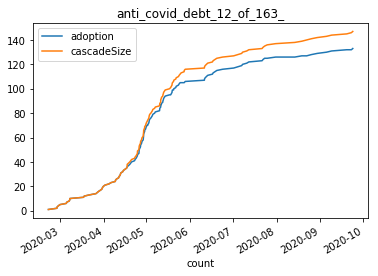

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


timebinMid
0.05    0.05
0.15    0.05
0.25    0.15
0.35    0.45
0.45    0.75
0.55    0.85
0.65    0.90
0.75    0.95
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


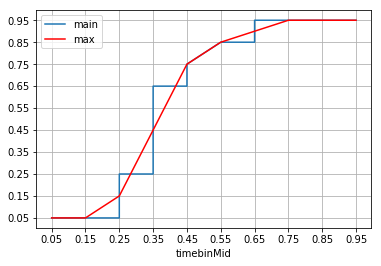

Processing: 13/163 : ['anti', 'covid', 'environmentalism', 'prejudice']
Processing: 14/163 : ['anti', 'covid', 'environmentalism']
Processing: 15/163 : ['anti', 'covid', 'infrastructure', 'mistreatment']
Processing: 16/163 : ['anti', 'covid', 'infrastructure', 'travel']
Processing: 17/163 : ['anti', 'covid', 'infrastructure']
Processing: 18/163 : ['anti', 'covid', 'mistreatment', 'prejudice', 'travel']
Processing: 19/163 : ['anti', 'covid', 'mistreatment', 'prejudice']
shape: (573, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


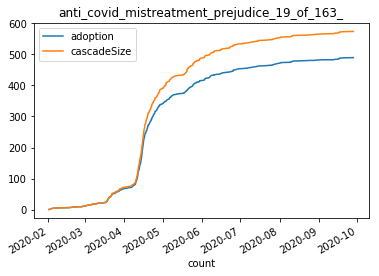

timebinMid
0.05    0.05
0.15    0.05
0.25    0.25
0.35    0.55
0.45    0.75
0.55    0.85
0.65    0.95
0.75    0.95
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


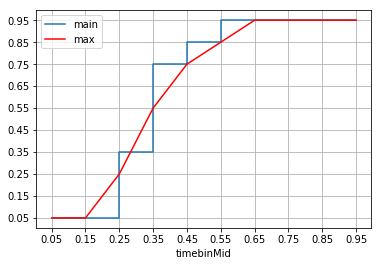

Processing: 20/163 : ['anti', 'covid', 'mistreatment', 'travel']
Processing: 21/163 : ['anti', 'covid', 'mistreatment']
shape: (433, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


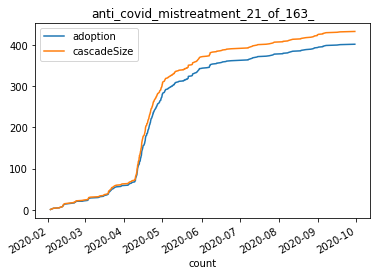

timebinMid
0.05    0.05
0.15    0.05
0.25    0.25
0.35    0.55
0.45    0.85
0.55    0.85
0.65    0.95
0.75    0.95
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


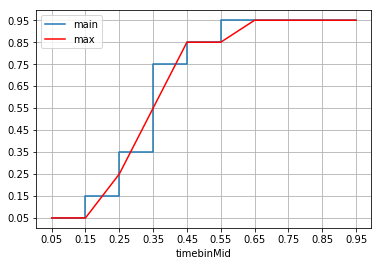

Processing: 22/163 : ['anti', 'covid', 'prejudice', 'travel']
Processing: 23/163 : ['anti', 'covid', 'prejudice']
shape: (803, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


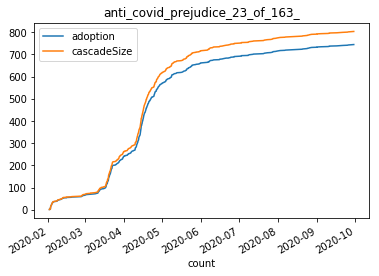

timebinMid
0.05    0.05
0.15    0.15
0.25    0.35
0.35    0.65
0.45    0.85
0.55    0.95
0.65    0.95
0.75    0.95
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


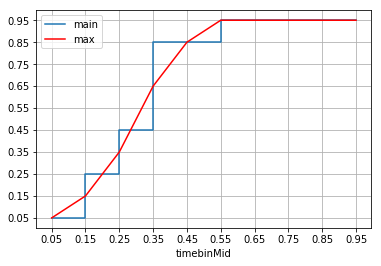

Processing: 24/163 : ['anti', 'covid', 'travel', 'un']
Processing: 25/163 : ['anti', 'covid', 'travel']
shape: (439, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


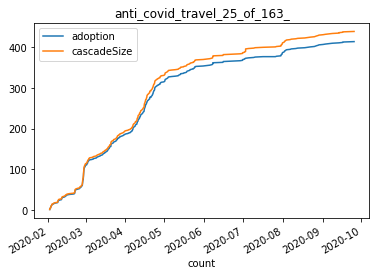

timebinMid
0.05    0.05
0.15    0.25
0.25    0.45
0.35    0.65
0.45    0.85
0.55    0.85
0.65    0.95
0.75    0.95
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


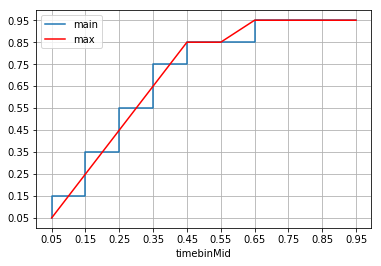

Processing: 26/163 : ['anti', 'covid', 'un']
Processing: 27/163 : ['anti', 'covid']
shape: (3610, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


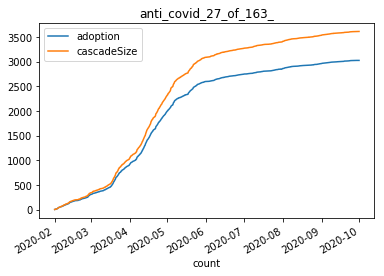

timebinMid
0.05    0.05
0.15    0.15
0.25    0.35
0.35    0.55
0.45    0.75
0.55    0.85
0.65    0.95
0.75    0.95
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


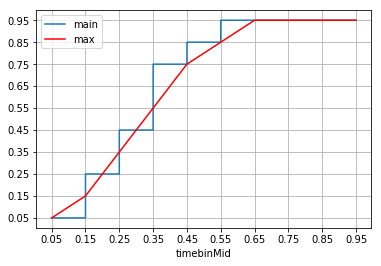

Processing: 28/163 : ['anti', 'debt', 'infrastructure', 'mistreatment']
Processing: 29/163 : ['anti', 'debt', 'infrastructure']
shape: (525, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


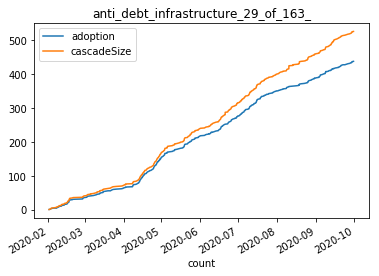

timebinMid
0.05    0.05
0.15    0.15
0.25    0.15
0.35    0.25
0.45    0.45
0.55    0.55
0.65    0.65
0.75    0.85
0.85    0.85
0.95    0.95
Name: valbinMid, dtype: float64


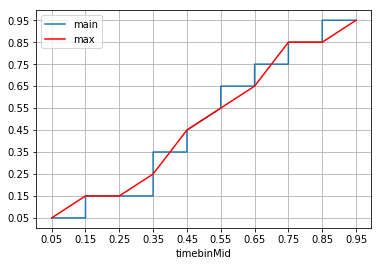

Processing: 30/163 : ['anti', 'debt', 'mistreatment', 'prejudice']
Processing: 31/163 : ['anti', 'debt', 'mistreatment']
Processing: 32/163 : ['anti', 'debt', 'prejudice']
Processing: 33/163 : ['anti', 'debt', 'travel']
Processing: 34/163 : ['anti', 'debt', 'un']
Processing: 35/163 : ['anti', 'debt']
shape: (2509, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


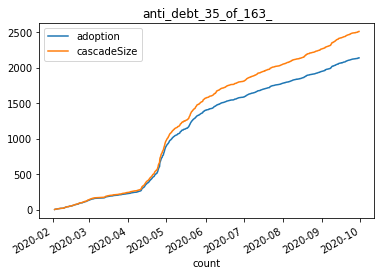

timebinMid
0.05    0.05
0.15    0.05
0.25    0.15
0.35    0.35
0.45    0.55
0.55    0.65
0.65    0.75
0.75    0.85
0.85    0.85
0.95    0.95
Name: valbinMid, dtype: float64


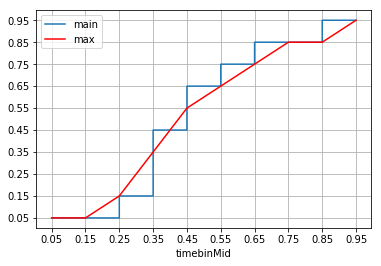

Processing: 36/163 : ['anti', 'environmentalism', 'infrastructure']
Processing: 37/163 : ['anti', 'environmentalism', 'mistreatment', 'prejudice']
Processing: 38/163 : ['anti', 'environmentalism', 'mistreatment']
Processing: 39/163 : ['anti', 'environmentalism', 'prejudice']
Processing: 40/163 : ['anti', 'environmentalism']
shape: (534, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


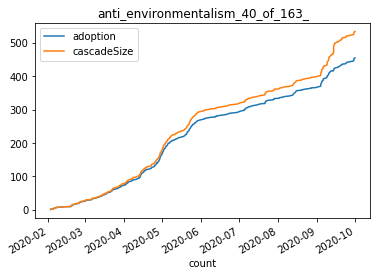

timebinMid
0.05    0.05
0.15    0.05
0.25    0.15
0.35    0.35
0.45    0.55
0.55    0.65
0.65    0.65
0.75    0.75
0.85    0.85
0.95    0.95
Name: valbinMid, dtype: float64


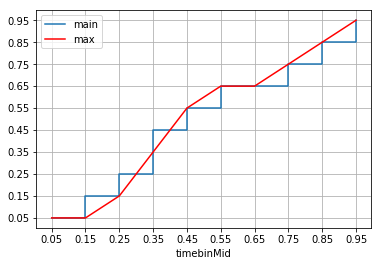

Processing: 41/163 : ['anti', 'infrastructure', 'mistreatment', 'prejudice']
Processing: 42/163 : ['anti', 'infrastructure', 'mistreatment']
Processing: 43/163 : ['anti', 'infrastructure', 'prejudice']
Processing: 44/163 : ['anti', 'infrastructure', 'travel']
Processing: 45/163 : ['anti', 'infrastructure', 'un']
Processing: 46/163 : ['anti', 'infrastructure']
shape: (1382, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


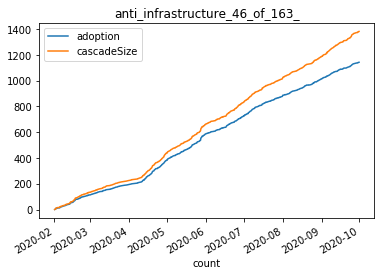

timebinMid
0.05    0.05
0.15    0.15
0.25    0.15
0.35    0.25
0.45    0.45
0.55    0.55
0.65    0.65
0.75    0.75
0.85    0.85
0.95    0.95
Name: valbinMid, dtype: float64


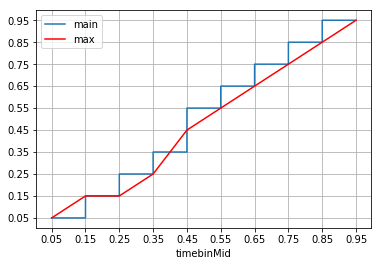

Processing: 47/163 : ['anti', 'mistreatment', 'prejudice', 'travel']
Processing: 48/163 : ['anti', 'mistreatment', 'prejudice', 'un']
Processing: 49/163 : ['anti', 'mistreatment', 'prejudice']
shape: (3320, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


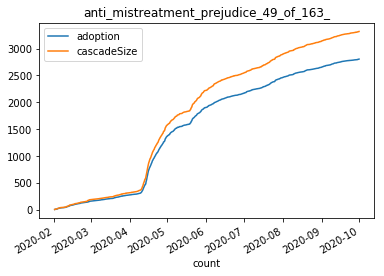

timebinMid
0.05    0.05
0.15    0.05
0.25    0.15
0.35    0.35
0.45    0.65
0.55    0.75
0.65    0.75
0.75    0.85
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


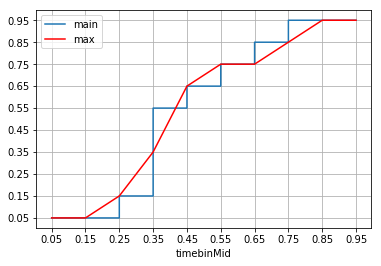

Processing: 50/163 : ['anti', 'mistreatment', 'travel']
Processing: 51/163 : ['anti', 'mistreatment', 'un']
Processing: 52/163 : ['anti', 'mistreatment']
shape: (5325, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


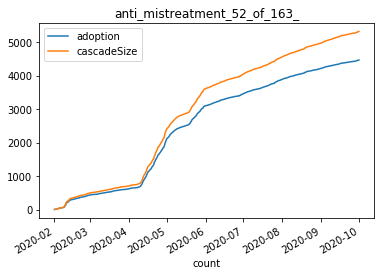

timebinMid
0.05    0.05
0.15    0.15
0.25    0.15
0.35    0.35
0.45    0.65
0.55    0.75
0.65    0.75
0.75    0.85
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


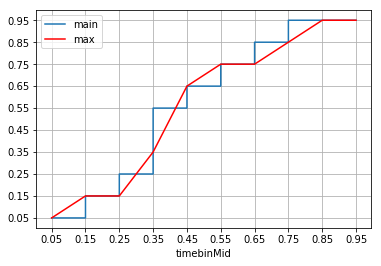

Processing: 53/163 : ['anti', 'prejudice', 'travel']
Processing: 54/163 : ['anti', 'prejudice', 'un']
Processing: 55/163 : ['anti', 'prejudice']
shape: (4279, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


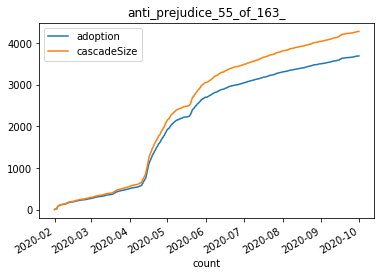

timebinMid
0.05    0.05
0.15    0.05
0.25    0.15
0.35    0.35
0.45    0.65
0.55    0.75
0.65    0.85
0.75    0.85
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


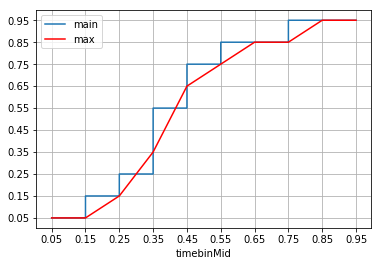

Processing: 56/163 : ['anti', 'travel']
shape: (877, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


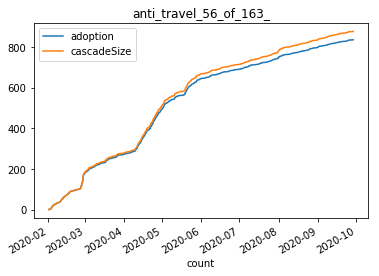

timebinMid
0.05    0.05
0.15    0.25
0.25    0.35
0.35    0.55
0.45    0.75
0.55    0.75
0.65    0.85
0.75    0.85
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


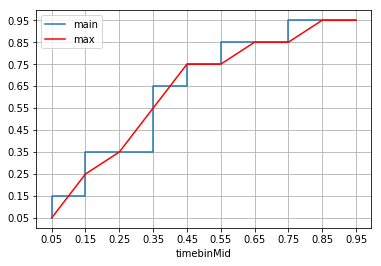

Processing: 57/163 : ['anti', 'un']
shape: (274, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


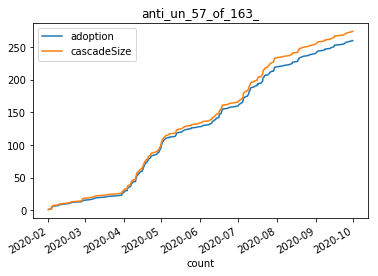

timebinMid
0.05    0.05
0.15    0.05
0.25    0.15
0.35    0.35
0.45    0.45
0.55    0.55
0.65    0.65
0.75    0.85
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


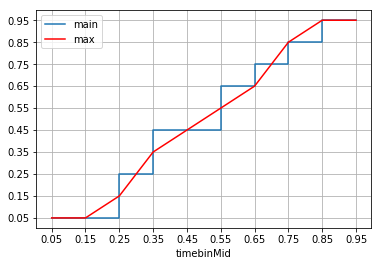

Processing: 58/163 : ['anti']
shape: (37730, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


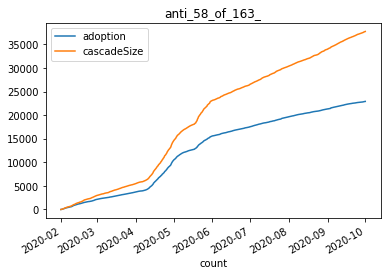

timebinMid
0.05    0.05
0.15    0.15
0.25    0.15
0.35    0.35
0.45    0.65
0.55    0.75
0.65    0.75
0.75    0.85
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


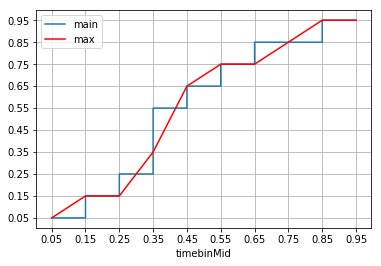

Processing: 59/163 : ['chinese-affiliated-account', 'covid', 'debt']
Processing: 60/163 : ['chinese-affiliated-account', 'covid', 'environmentalism']
Processing: 61/163 : ['chinese-affiliated-account', 'covid', 'infrastructure', 'pro']
Processing: 62/163 : ['chinese-affiliated-account', 'covid', 'infrastructure']
Processing: 63/163 : ['chinese-affiliated-account', 'covid', 'mistreatment']
Processing: 64/163 : ['chinese-affiliated-account', 'covid', 'prejudice', 'pro']
Processing: 65/163 : ['chinese-affiliated-account', 'covid', 'prejudice']
Processing: 66/163 : ['chinese-affiliated-account', 'covid', 'pro', 'travel']
Processing: 67/163 : ['chinese-affiliated-account', 'covid', 'pro', 'un']
Processing: 68/163 : ['chinese-affiliated-account', 'covid', 'pro']
Processing: 69/163 : ['chinese-affiliated-account', 'covid', 'travel']
Processing: 70/163 : ['chinese-affiliated-account', 'covid', 'un']
Processing: 71/163 : ['chinese-affiliated-account', 'covid']
Processing: 72/163 : ['chinese-aff

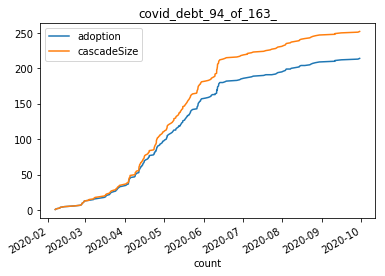

timebinMid
0.05    0.05
0.15    0.05
0.25    0.25
0.35    0.45
0.45    0.65
0.55    0.75
0.65    0.85
0.75    0.95
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


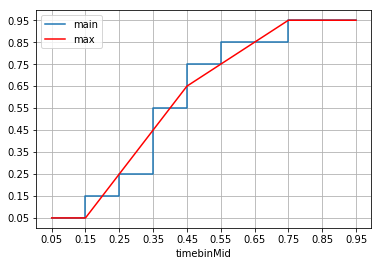

Processing: 95/163 : ['covid', 'environmentalism', 'pro']
Processing: 96/163 : ['covid', 'environmentalism']
Processing: 97/163 : ['covid', 'infrastructure', 'mistreatment']
Processing: 98/163 : ['covid', 'infrastructure', 'prejudice']
Processing: 99/163 : ['covid', 'infrastructure', 'pro']
Processing: 100/163 : ['covid', 'infrastructure', 'travel']
Processing: 101/163 : ['covid', 'infrastructure']
shape: (151, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


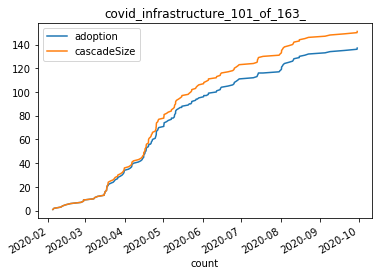

timebinMid
0.05    0.05
0.15    0.15
0.25    0.25
0.35    0.45
0.45    0.65
0.55    0.75
0.65    0.85
0.75    0.85
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


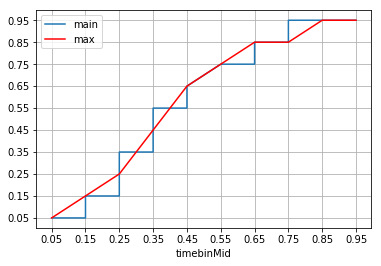

Processing: 102/163 : ['covid', 'mistreatment', 'prejudice', 'pro']
Processing: 103/163 : ['covid', 'mistreatment', 'prejudice', 'travel']
Processing: 104/163 : ['covid', 'mistreatment', 'prejudice']
Processing: 105/163 : ['covid', 'mistreatment', 'pro', 'travel']
Processing: 106/163 : ['covid', 'mistreatment', 'pro']
Processing: 107/163 : ['covid', 'mistreatment', 'travel']
Processing: 108/163 : ['covid', 'mistreatment']
shape: (274, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


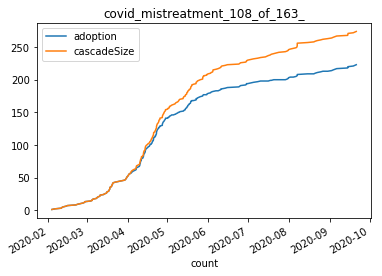

timebinMid
0.05    0.05
0.15    0.15
0.25    0.25
0.35    0.55
0.45    0.75
0.55    0.85
0.65    0.85
0.75    0.95
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


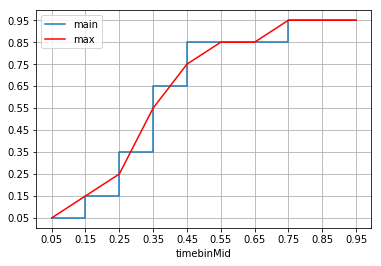

Processing: 109/163 : ['covid', 'prejudice', 'pro', 'travel']
Processing: 110/163 : ['covid', 'prejudice', 'pro']
Processing: 111/163 : ['covid', 'prejudice', 'travel']
Processing: 112/163 : ['covid', 'prejudice']
shape: (572, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


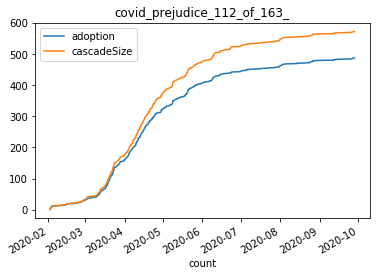

timebinMid
0.05    0.05
0.15    0.15
0.25    0.35
0.35    0.65
0.45    0.75
0.55    0.85
0.65    0.95
0.75    0.95
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


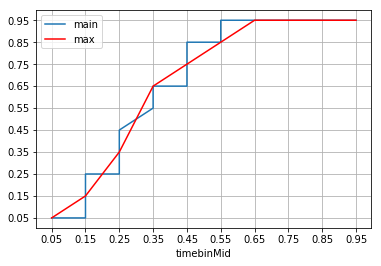

Processing: 113/163 : ['covid', 'pro', 'travel']
Processing: 114/163 : ['covid', 'pro', 'un']
Processing: 115/163 : ['covid', 'pro']
shape: (919, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


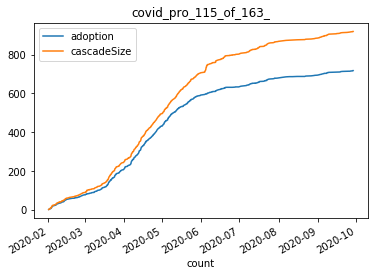

timebinMid
0.05    0.05
0.15    0.15
0.25    0.35
0.35    0.55
0.45    0.75
0.55    0.85
0.65    0.95
0.75    0.95
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


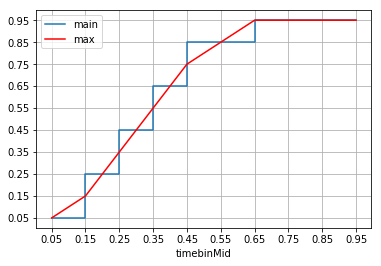

Processing: 116/163 : ['covid', 'travel', 'un']
Processing: 117/163 : ['covid', 'travel']
shape: (2446, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


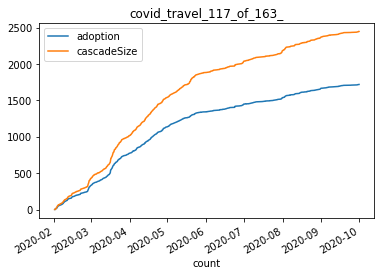

timebinMid
0.05    0.05
0.15    0.25
0.25    0.45
0.35    0.65
0.45    0.75
0.55    0.85
0.65    0.85
0.75    0.85
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


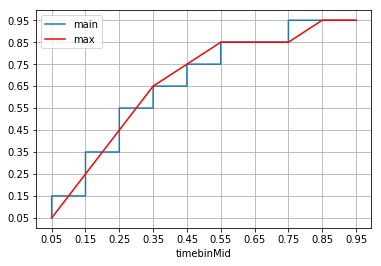

Processing: 118/163 : ['covid', 'un']
Processing: 119/163 : ['covid']
shape: (20251, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


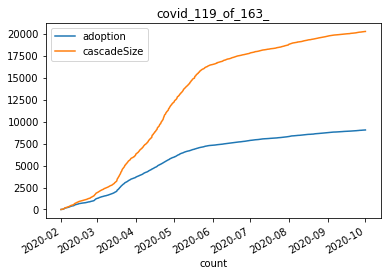

timebinMid
0.05    0.05
0.15    0.25
0.25    0.45
0.35    0.65
0.45    0.75
0.55    0.85
0.65    0.85
0.75    0.95
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


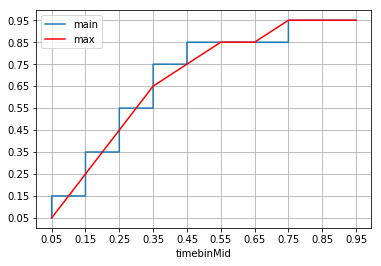

Processing: 120/163 : ['debt', 'infrastructure', 'pro']
Processing: 121/163 : ['debt', 'infrastructure']
shape: (322, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


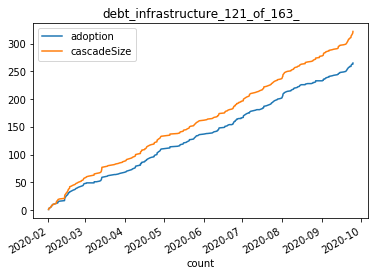

timebinMid
0.05    0.05
0.15    0.15
0.25    0.25
0.35    0.35
0.45    0.45
0.55    0.55
0.65    0.65
0.75    0.75
0.85    0.85
0.95    0.95
Name: valbinMid, dtype: float64


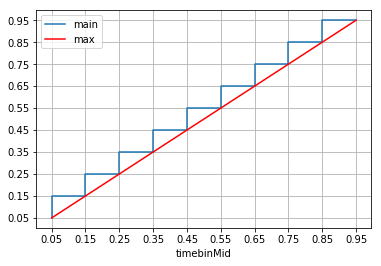

Processing: 122/163 : ['debt', 'mistreatment', 'pro']
Processing: 123/163 : ['debt', 'mistreatment']
Processing: 124/163 : ['debt', 'prejudice', 'pro']
Processing: 125/163 : ['debt', 'prejudice']
Processing: 126/163 : ['debt', 'pro', 'travel']
Processing: 127/163 : ['debt', 'pro']
shape: (127, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


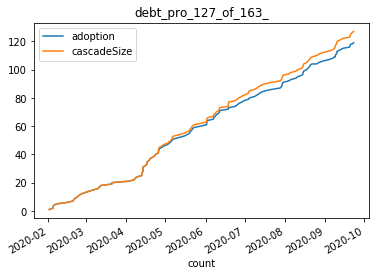

timebinMid
0.05    0.05
0.15    0.15
0.25    0.25
0.35    0.35
0.45    0.45
0.55    0.55
0.65    0.65
0.75    0.75
0.85    0.85
0.95    0.95
Name: valbinMid, dtype: float64


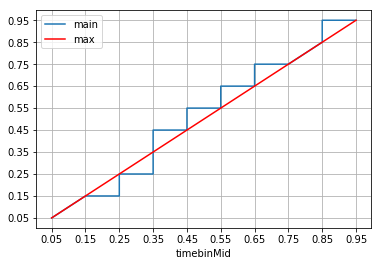

Processing: 128/163 : ['debt', 'travel']
Processing: 129/163 : ['debt']
shape: (3292, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


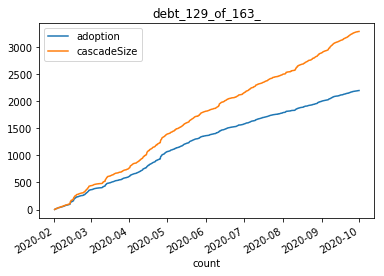

timebinMid
0.05    0.05
0.15    0.15
0.25    0.25
0.35    0.45
0.45    0.55
0.55    0.65
0.65    0.75
0.75    0.85
0.85    0.85
0.95    0.95
Name: valbinMid, dtype: float64


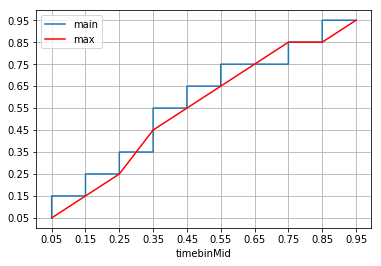

Processing: 130/163 : ['environmentalism', 'infrastructure', 'pro']
Processing: 131/163 : ['environmentalism', 'infrastructure']
Processing: 132/163 : ['environmentalism', 'mistreatment']
Processing: 133/163 : ['environmentalism', 'prejudice']
Processing: 134/163 : ['environmentalism', 'pro']
Processing: 135/163 : ['environmentalism']
shape: (892, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


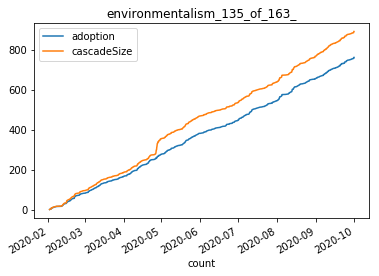

timebinMid
0.05    0.05
0.15    0.15
0.25    0.25
0.35    0.35
0.45    0.45
0.55    0.55
0.65    0.65
0.75    0.75
0.85    0.85
0.95    0.95
Name: valbinMid, dtype: float64


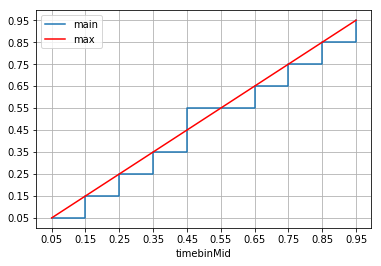

Processing: 136/163 : ['infrastructure', 'mistreatment', 'prejudice']
Processing: 137/163 : ['infrastructure', 'mistreatment', 'pro']
Processing: 138/163 : ['infrastructure', 'mistreatment', 'travel']
Processing: 139/163 : ['infrastructure', 'mistreatment']
Processing: 140/163 : ['infrastructure', 'prejudice']
Processing: 141/163 : ['infrastructure', 'pro', 'travel']
Processing: 142/163 : ['infrastructure', 'pro']
shape: (575, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


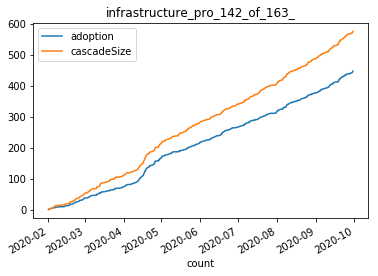

timebinMid
0.05    0.05
0.15    0.15
0.25    0.15
0.35    0.35
0.45    0.45
0.55    0.55
0.65    0.65
0.75    0.75
0.85    0.85
0.95    0.95
Name: valbinMid, dtype: float64


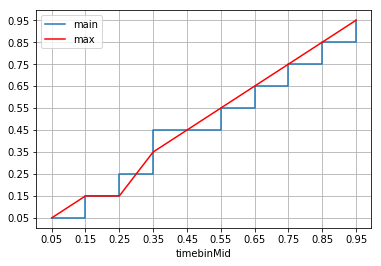

Processing: 143/163 : ['infrastructure', 'travel']
Processing: 144/163 : ['infrastructure']
shape: (5991, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


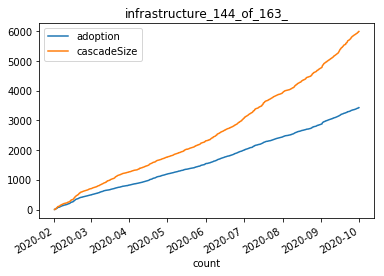

timebinMid
0.05    0.05
0.15    0.15
0.25    0.25
0.35    0.35
0.45    0.45
0.55    0.55
0.65    0.65
0.75    0.75
0.85    0.85
0.95    0.95
Name: valbinMid, dtype: float64


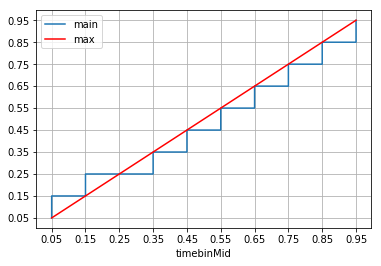

Processing: 145/163 : ['mistreatment', 'prejudice', 'pro']
Processing: 146/163 : ['mistreatment', 'prejudice', 'travel']
Processing: 147/163 : ['mistreatment', 'prejudice', 'un']
Processing: 148/163 : ['mistreatment', 'prejudice']
shape: (1138, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


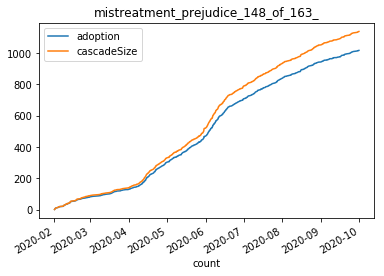

timebinMid
0.05    0.05
0.15    0.05
0.25    0.15
0.35    0.25
0.45    0.45
0.55    0.55
0.65    0.75
0.75    0.85
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


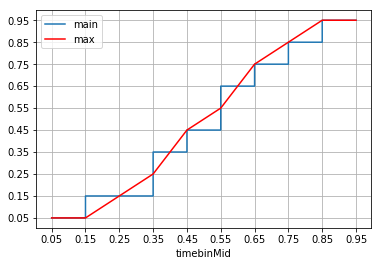

Processing: 149/163 : ['mistreatment', 'pro', 'un']
Processing: 150/163 : ['mistreatment', 'pro']
shape: (122, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


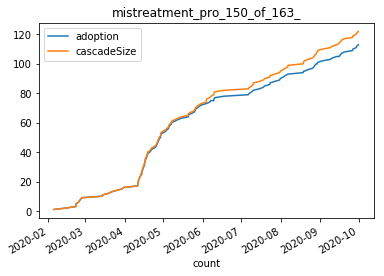

timebinMid
0.05    0.05
0.15    0.05
0.25    0.15
0.35    0.35
0.45    0.55
0.55    0.65
0.65    0.75
0.75    0.75
0.85    0.85
0.95    0.95
Name: valbinMid, dtype: float64


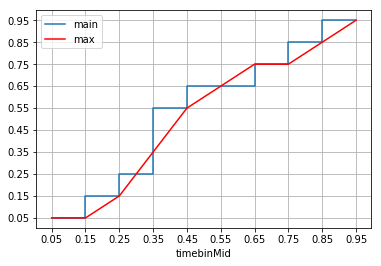

Processing: 151/163 : ['mistreatment', 'travel']
Processing: 152/163 : ['mistreatment', 'un']
Processing: 153/163 : ['mistreatment']
shape: (4164, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


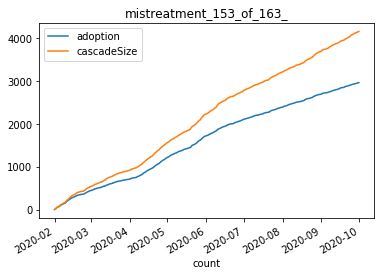

timebinMid
0.05    0.05
0.15    0.15
0.25    0.25
0.35    0.35
0.45    0.55
0.55    0.65
0.65    0.75
0.75    0.85
0.85    0.85
0.95    0.95
Name: valbinMid, dtype: float64


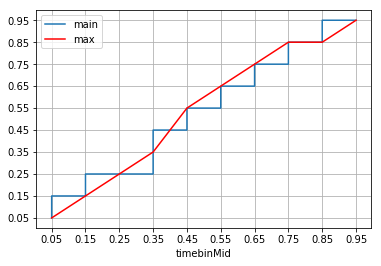

Processing: 154/163 : ['prejudice', 'pro', 'travel']
Processing: 155/163 : ['prejudice', 'pro']
Processing: 156/163 : ['prejudice', 'travel']
Processing: 157/163 : ['prejudice', 'un']
Processing: 158/163 : ['prejudice']
shape: (3712, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


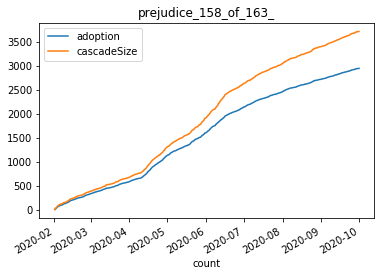

timebinMid
0.05    0.05
0.15    0.15
0.25    0.25
0.35    0.35
0.45    0.45
0.55    0.65
0.65    0.75
0.75    0.85
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


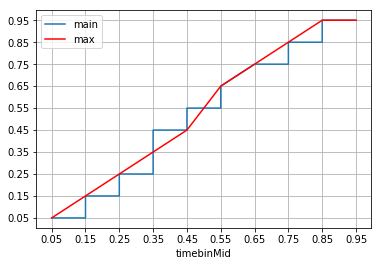

Processing: 159/163 : ['pro', 'travel']
Processing: 160/163 : ['pro', 'un']
Processing: 161/163 : ['pro']
shape: (4399, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


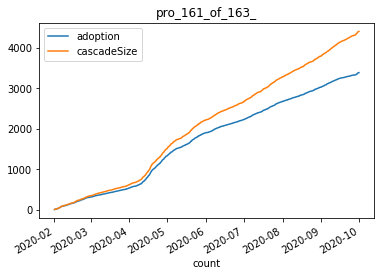

timebinMid
0.05    0.05
0.15    0.15
0.25    0.15
0.35    0.35
0.45    0.55
0.55    0.65
0.65    0.65
0.75    0.75
0.85    0.85
0.95    0.95
Name: valbinMid, dtype: float64


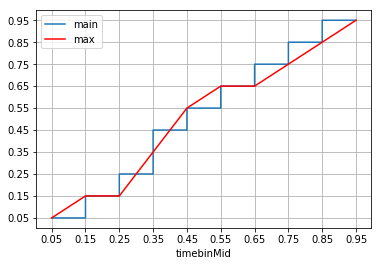

Processing: 162/163 : ['travel']
shape: (3213, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


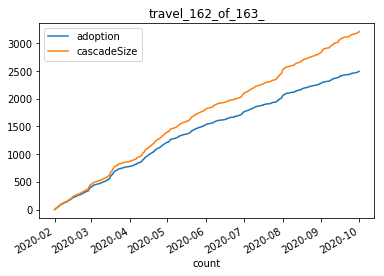

timebinMid
0.05    0.05
0.15    0.25
0.25    0.35
0.35    0.45
0.45    0.55
0.55    0.65
0.65    0.75
0.75    0.85
0.85    0.85
0.95    0.95
Name: valbinMid, dtype: float64


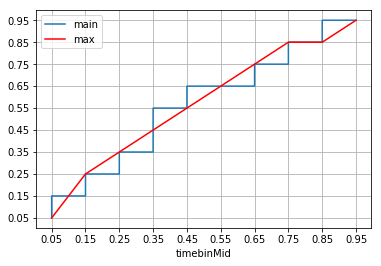

Processing: 163/163 : ['un']
shape: (637, 4)
cols: Index(['time', 'userID', 'adoption', 'cascadeSize'], dtype='object')


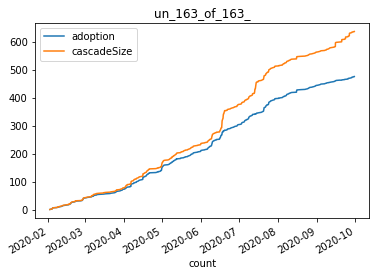

timebinMid
0.05    0.05
0.15    0.05
0.25    0.15
0.35    0.25
0.45    0.35
0.55    0.55
0.65    0.75
0.75    0.85
0.85    0.95
0.95    0.95
Name: valbinMid, dtype: float64


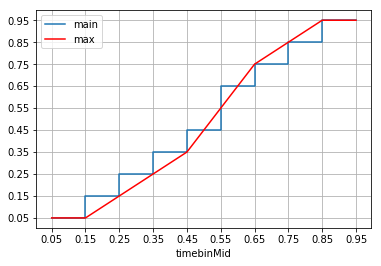

done


In [32]:
dfobj.generateData("multi")

In [ ]:
def calcSampledCurve(resultdf, valColName, startTime, endTime, timeNumBins=100, valNumBins=100):
        #print(resultdf.head())
        maxSeconds = (endTime - startTime).total_seconds()
        resultdf['timefrac'] = resultdf['time'].apply(lambda x: (x - startTime).total_seconds() / maxSeconds)
        maxValue = resultdf[valColName].max()
        resultdf['valfrac'] = resultdf[valColName].apply(lambda x: x/maxValue)
        #print(resultdf)
        resultdf['timebin'] = pd.cut(resultdf['timefrac'],bins=np.linspace(0, 1, 1 + timeNumBins))
        resultdf['valbin'] = pd.cut(resultdf.valfrac,bins=np.linspace(0, 1, 1 + valNumBins))
        #print(resultdf['timebin'].cat.categories)
        #print(resultdf['valbin'].cat.categories)
        #print(resultdf)
        sampled_df = resultdf[['timebin','valbin']]
        sampled_df = sampled_df.drop_duplicates()
        sampled_df['timebinNo'] = sampled_df['timebin'].cat.codes / (timeNumBins - 1)
        sampled_df['valbinNo'] = sampled_df['valbin'].cat.codes / (valNumBins - 1)
        #print(sampled_df)
        sampled_df.set_index('timebinNo')['valbinNo'].plot()

In [ ]:
df = pd.read_csv('/home/social-sim/RESEARCH/DOI_Inverse/doiemd/outputs/anti_environmentalism_45_of_176_.csv',parse_dates=['time'])

In [ ]:
calcSampledCurve(df[(df.time < pd.Timestamp(2020,10,1)) & (df.time > pd.Timestamp(2020,2,1))], "adoption", pd.Timestamp(2020,2,1), pd.Timestamp(2020,10,1))

# dummy comparison


In [ ]:
def calcRootInfo(thisRoot):
    this_event_time_user = df[df['conversationID'] == thisRoot][['time','userID']].reset_index(drop=True)
    lifespan = this_event_time_user.time.iloc[-1] - this_event_time_user.time.iloc[0]
    return [thisRoot, lifespan, this_event_time_user.shape[0], len(this_event_time_user.userID.unique())]

In [ ]:
root_info_lines = []

for thisRoot in roots:
    root_info_lines.append(calcRootInfo(thisRoot))

df_root_info = pd.DataFrame(root_info_lines, columns=['rootID','lifespan','numEvents','numUsers'])

In [ ]:
df_root_info['lifedays'] = df_root_info.lifespan.apply(lambda x: x.days)

In [ ]:
ina = np.array(df_root_info[(df_root_info.lifedays > 0) & (df_root_info.lifedays < 9999)].lifedays.tolist())
print(ina)

print("shape: {}".format(ina.shape))

plt.hist(ina)

In [ ]:
from sklearn.neighbors.kde import KernelDensity

#a = np.array([10,11,9,23,21,11,45,20,11,12]).reshape(-1, 1)
a = ina.reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)
s = np.linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plt.plot(s, e)

In [ ]:
from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

In [ ]:
sections = [ [s[:mi[0]+1], e[:mi[0]+1], 'r'] ]
cur = 1
while( cur < len(mi) ):
    sections.append([s[mi[cur - 1]:mi[cur] + 1], e[mi[cur - 1]:mi[cur] + 1], 'r' if cur % 2 == 0 else 'g'])
    cur += 1
    
sections.append([s[mi[cur - 1]:], e[mi[cur - 1]:], 'r' if cur % 2 == 0 else 'g'])

In [ ]:
for sect in sections:
    plt.plot(sect[0],sect[1],sect[2])
    
plt.plot(#s[:mi[0]+1], e[:mi[0]+1], 'r',
     #s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     #s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

In [ ]:
groundTruth_df = pd.read_csv("/home/social-sim/RESEARCH/DOI_Inverse/doiemd/outputs/anti_58_of_163__binned_10x10.csv")
groundTruth_df = groundTruth_df[['timebinNo','valbinNo']]
groundTruth_df = groundTruth_df[groundTruth_df['timebinNo'] != 0]
groundTruth_df = groundTruth_df.groupby('timebinNo').max()['valbinNo']
print(groundTruth_df)

In [ ]:
dfdummy = pd.read_csv("/home/social-sim/RESEARCH/DOI_Inverse/doiemd/outputs/anti_covid_debt_12_of_163__binned_10x10.csv")
dfdummy = dfdummy[['timebinNo','valbinNo']]
dfdummy = dfdummy[dfdummy['timebinNo'] != 0]
dfdummy = dfdummy.groupby('timebinNo').max()['valbinNo']
print(dfdummy)

In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))

In [ ]:
def mape_df(actual_df, pred_df): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))